In [3]:
import gcp.bigquery as bq


In [47]:
%%sql --module hn

DEFINE QUERY top_types
SELECT type, COUNT(*) c
FROM [fh-bigquery:hackernews.full_201510] 
GROUP BY 1
ORDER BY 2 
LIMIT 100

DEFINE QUERY counts
SELECT a.month month, stories, comments, comment_authors, story_authors
FROM (
  SELECT STRFTIME_UTC_USEC(time_ts, '%Y-%m') month, COUNT(*) stories, EXACT_COUNT_DISTINCT(author) story_authors
  FROM [fh-bigquery:hackernews.stories] 
  GROUP BY 1
) a
JOIN (
  SELECT STRFTIME_UTC_USEC(time_ts, '%Y-%m') month, COUNT(*) comments, EXACT_COUNT_DISTINCT(author) comment_authors
  FROM [fh-bigquery:hackernews.comments] 
  GROUP BY 1
) b
ON a.month=b.month
ORDER BY 1

DEFINE QUERY score_per_hour
SELECT HOUR(SEC_TO_TIMESTAMP(time-3600*8)) hour, COUNT(*) stories, AVG(score) avg_score, SUM(score>30)/COUNT(*) prob
FROM [fh-bigquery:hackernews.stories] 
WHERE YEAR(time_ts)=2015
GROUP BY 1
ORDER BY 1

DEFINE QUERY comments_per_hour
SELECT HOUR(SEC_TO_TIMESTAMP(time-3600*8)) hour, COUNT(*) comments, AVG(ranking) avg_ranking, SUM(ranking<4)/COUNT(*) prob
FROM [fh-bigquery:hackernews.comments] 
WHERE YEAR(time_ts)=2015
GROUP BY 1
ORDER BY 1


In [4]:
bq.Query(hn.top_types).to_dataframe()

,type,c
0,poll,1616
1,job,6357
2,pollopt,11088
3,story,1959809
4,comment_ranking,8399638
5,comment,8399919


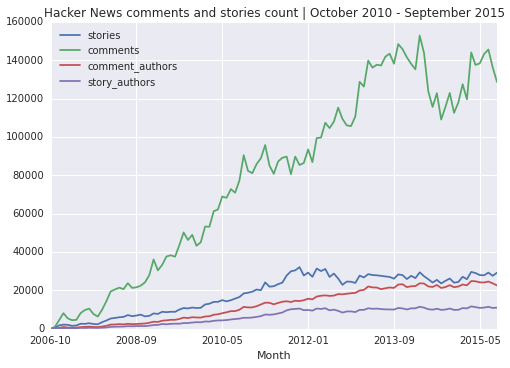

In [53]:
data=bq.Query(hn.counts).to_dataframe()[0:-1]
my_plot=data.set_index('month').plot(kind='line', title='Hacker News comments and stories count | October 2010 - September 2015')
my_plot.set_xlabel("Month")
#hAxis: {title: 'by twitter.com/felipehoffa, learn more at reddit.com/r/bigquery', titleTextStyle: {color: '#777777'}}



In [49]:
scores=bq.Query(hn.score_per_hour).to_dataframe()

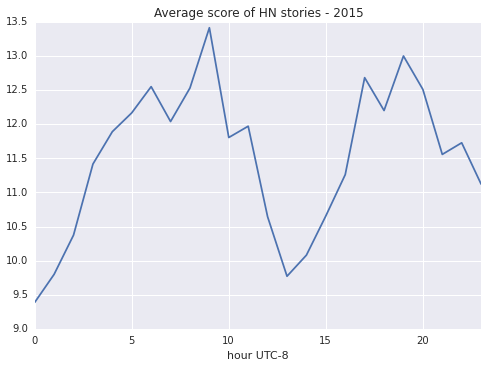

In [54]:
my_plot=scores.set_index('hour')['avg_score'].plot(kind='line', title='Average score of HN stories - 2015')
my_plot.set_xlabel("hour UTC-8")

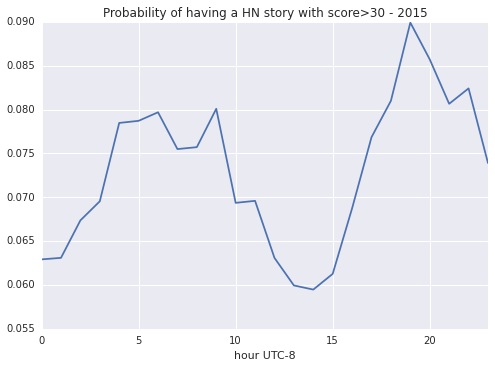

In [55]:
my_plot=scores.set_index('hour')['prob'].plot(kind='line', title='Probability of having a HN story with score>30 - 2015')
my_plot.set_xlabel("hour UTC-8")

In [56]:
comments = bq.Query(hn.comments_per_hour).to_dataframe()

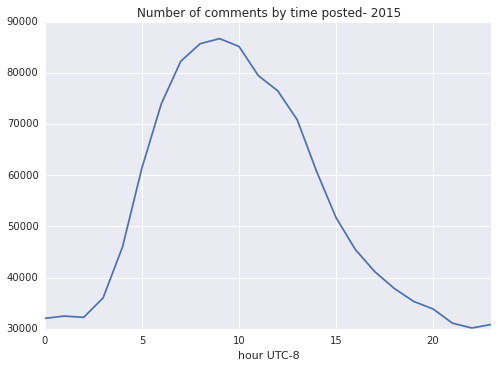

In [57]:
my_plot=comments.set_index('hour')['comments'].plot(kind='line', title='Number of comments by time posted- 2015')
my_plot.set_xlabel("hour UTC-8")

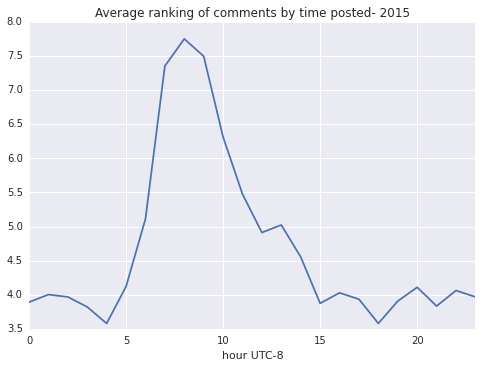

In [58]:
my_plot=comments.set_index('hour')['avg_ranking'].plot(kind='line', title='Average ranking of comments by time posted- 2015')
my_plot.set_xlabel("hour UTC-8")

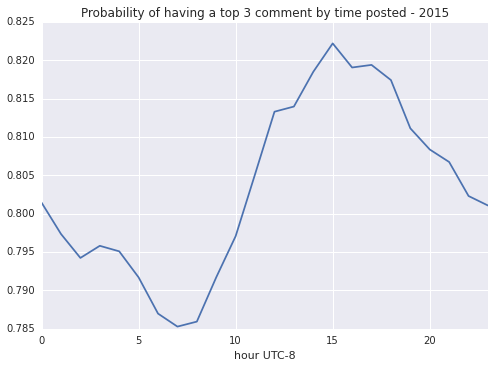

In [60]:
my_plot=comments.set_index('hour')['prob'].plot(kind='line', title='Probability of having a top 3 comment by time posted - 2015')
my_plot.set_xlabel("hour UTC-8")